In [109]:
import pandas as pd
import numpy as np
import os
import sys
sys.path.append('/content/jupyter/mta-accessibility')
# from src.data import process_turnstile
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt
import re 
import math 
%matplotlib inline
%config Completer.use_jedi = False

In [110]:
df = pd.read_pickle('../../data/processed/all_turnstiles_with_outage.pkl.gz')

In [111]:
df['Planned Outage'].value_counts()

False    809571
True      30353
Name: Planned Outage, dtype: int64

In [112]:
df = df[df.datetime.notnull()]
df.drop_duplicates(inplace=True)

In [113]:
def is_private(x):
    if pd.isna(x):
        return np.NaN
    else:
        if x.rfind('X') > 0:
            return 'Private'
        else:
            return 'MTA'

In [114]:
df.set_index('datetime',inplace=True)
df['flow'] = df['entry_diff_abs'] + df['exit_diff_abs']
df['maintained'] = [is_private(x) for x in df.equipment_id.values]
df.head()

,STATION,UNIT,equipment_id,station_name,Percentage,entry_diff_abs,exit_diff_abs,Planned Outage,subway_lines,flow,maintained
datetime,,,,,,,,,,,
2019-01-01 00:00:00,103 ST,R191,NaN,NaN,0.0,1892.00,840.0,NaN,NaN,2732.00,NaN
2019-01-01 01:00:00,103 ST,R191,NaN,NaN,0.0,1558.75,790.0,NaN,NaN,2348.75,NaN
2019-01-01 02:00:00,103 ST,R191,NaN,NaN,0.0,1225.50,740.0,NaN,NaN,1965.50,NaN
2019-01-01 03:00:00,103 ST,R191,NaN,NaN,0.0,892.25,690.0,NaN,NaN,1582.25,NaN
2019-01-01 04:00:00,103 ST,R191,NaN,NaN,0.0,559.00,640.0,NaN,NaN,1199.00,NaN


In [115]:
len(df.STATION.unique())

380

Althought there are 472 stations, turnstile data only has 380 listed

## Analysis plan

- Downtime measure
    - Identify worst equipments & stations
    - Compare privately maintained vs. MTA maintained
    - Daily/monthly aggregations including/excluding Planned outages
- Commuter impact
    - Scale downtime by % all commuters traveling through that station during outage times
    - Identify worst equipments & stations. Compare against downtime measure 
    - Are privately maintained equipments still worst offenders?
    - Daily/monthly aggregations
- Integrate Elevator network
    - Try to replicate MTA Accessibility Dashboard metric (which represents connections from street to platform)
    - Assign weights to elevators depending on intra-subway paths that the elevator disconnects

### Downtime measure
Ratio of time equipment is out to the total time expected to be operating

In [116]:
## looking at only elevators
df_elevators = df[(df.equipment_id.notnull()) & (df.equipment_id.str.contains('EL'))]
df_escalators = df[(df.equipment_id.notnull()) & (df.equipment_id.str.contains('ES'))]

In [117]:
df_elevators['Planned Outage'].value_counts()

False    177103
True      18630
Name: Planned Outage, dtype: int64

#### Worst equipments/stations

In [118]:
daily_downtime_by_el = df_elevators.groupby([df_elevators.index.floor('d'),'equipment_id','maintained']).sum()['Percentage'].div(df_elevators.groupby([df_elevators.index.floor('d'),'equipment_id','maintained']).count()['Percentage']).reset_index()
daily_downtime_by_st = df_elevators.groupby([df_elevators.index.floor('d'),'STATION']).sum()['Percentage'].div(df_elevators.groupby([df_elevators.index.floor('d'),'STATION']).count()['Percentage']).reset_index()

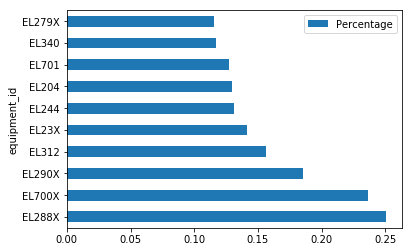

In [119]:
daily_downtime_by_el.groupby('equipment_id').mean().sort_values('Percentage',ascending=False).head(10).plot.barh()

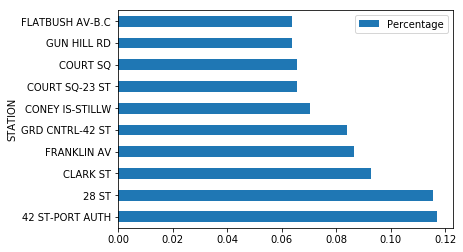

In [120]:
daily_downtime_by_st.groupby('STATION').mean().sort_values('Percentage',ascending=False).head(10).plot.barh()

#### System-wide measure

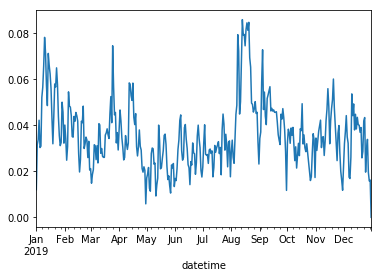

In [121]:
daily_downtime_by_el.groupby('datetime').mean().Percentage.plot()

Text(0.5, 0, 'Month')

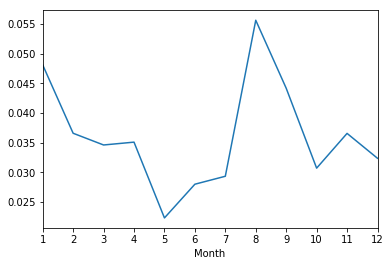

In [122]:
monthly_downtime = daily_downtime_by_el.groupby(pd.DatetimeIndex(daily_downtime_by_el.datetime).month).mean().Percentage
ax = monthly_downtime.plot(xticks=range(1,13))
ax.set_xlabel('Month')

#### MTA maintained vs. privately maintained

In [123]:
el_downtime_by_private = daily_downtime_by_el.groupby([pd.DatetimeIndex(daily_downtime_by_el.datetime).month,'maintained']).mean().reset_index()

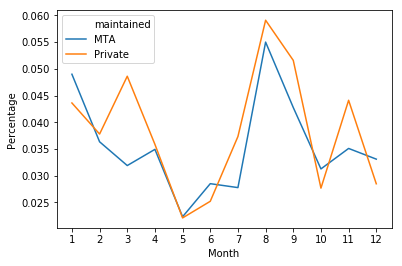

In [124]:
ax = sns.lineplot(x='datetime',y='Percentage',hue='maintained',data=el_downtime_by_private)
ax.set_xlabel('Month')
ax.set_xticks(range(1,13))

#### Excluding planned outages
Planned outages could include Maintenance and Capital replacement. Ideally, we should only exclude capital replacement and probably study the number of commuters impacted during planned maintenance. Until we disaggregate those, excluding all planned outages just for comparison

Text(0.5, 0, 'Month')

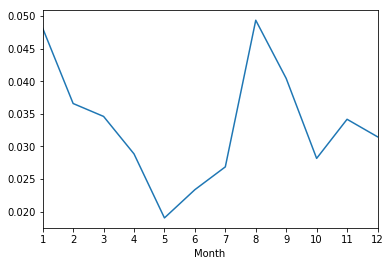

In [125]:
df_el_unplanned = df_elevators[df_elevators['Planned Outage'] != True]
daily_downtime_by_el_up = df_el_unplanned.groupby([df_el_unplanned.index.floor('d'),'equipment_id','maintained']).sum()['Percentage'].div(df_el_unplanned.groupby([df_el_unplanned.index.floor('d'),'equipment_id','maintained']).count()['Percentage']).reset_index()
ax = daily_downtime_by_el_up.groupby(pd.DatetimeIndex(daily_downtime_by_el_up.datetime).month).mean().Percentage.plot(xticks=range(1,13))
ax.set_xlabel('Month')

In [126]:
daily_downtime_by_el_up.groupby(pd.DatetimeIndex(daily_downtime_by_el_up.datetime).month).mean().Percentage

datetime
1     0.048118
2     0.036579
3     0.034600
4     0.028856
5     0.019039
6     0.023368
7     0.026865
8     0.049346
9     0.040426
10    0.028165
11    0.034162
12    0.031478
Name: Percentage, dtype: float64

In [127]:
monthly_downtime

datetime
1     0.048118
2     0.036579
3     0.034600
4     0.035080
5     0.022288
6     0.027977
7     0.029320
8     0.055656
9     0.044182
10    0.030690
11    0.036556
12    0.032354
Name: Percentage, dtype: float64

### Escalators

In [128]:
daily_downtime_by_es = df_escalators.groupby([df_escalators.index.floor('d'),'equipment_id','maintained']).sum()['Percentage'].div(df_escalators.groupby([df_escalators.index.floor('d'),'equipment_id','maintained']).count()['Percentage']).reset_index()
es_downtime_by_private = daily_downtime_by_es.groupby([pd.DatetimeIndex(daily_downtime_by_es.datetime).month,'maintained']).mean().reset_index()

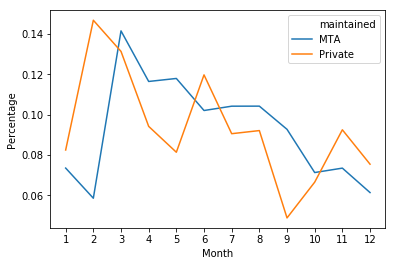

In [129]:
ax = sns.lineplot(x='datetime',y='Percentage',hue='maintained',data=es_downtime_by_private)
ax.set_xlabel('Month')
ax.set_xticks(range(1,13))

### Commuter impact

#### Commuter hours downtime  
Number of commuters at each hour of outage at each station / total number of commuters at that station

In [130]:
df_elevators['flow_pct'] = df_elevators['flow']*df_elevators['Percentage']
daily_ch_dt_by_el = df_elevators.groupby([df_elevators.index.floor('d'),'equipment_id','maintained']).sum()['flow_pct'].div(df_elevators.groupby([df_elevators.index.floor('d'),'equipment_id','maintained']).sum()['flow']).reset_index()
daily_ch_dt_by_st = df_elevators.groupby([df_elevators.index.floor('d'),'STATION','maintained']).sum()['flow_pct'].div(df_elevators.groupby([df_elevators.index.floor('d'),'STATION','maintained']).sum()['flow']).reset_index()

/opt/conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


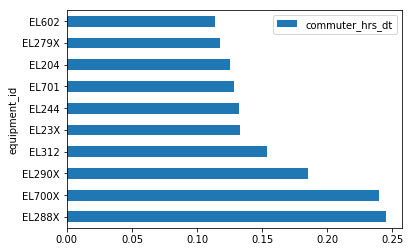

In [131]:
daily_ch_dt_by_el.rename(columns={0:'commuter_hrs_dt'},inplace=True)
daily_ch_dt_by_el.groupby('equipment_id').mean().sort_values('commuter_hrs_dt',ascending=False).head(10).plot.barh()

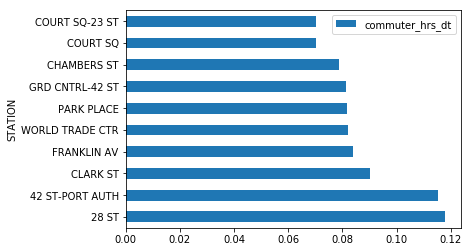

In [132]:
daily_ch_dt_by_st.rename(columns={0:'commuter_hrs_dt'},inplace=True)
daily_ch_dt_by_st.groupby('STATION').mean().sort_values('commuter_hrs_dt',ascending=False).head(10).plot.barh()

In [133]:
metrics_by_el = daily_ch_dt_by_el.groupby('equipment_id').mean().merge(daily_downtime_by_el.groupby('equipment_id').mean(),on='equipment_id')
metrics_by_st = daily_ch_dt_by_st.groupby('STATION').mean().merge(daily_downtime_by_st.groupby('STATION').mean(),on='STATION')

In [134]:
metrics_by_el['avg'] = abs(metrics_by_el['Percentage'] + metrics_by_el['commuter_hrs_dt'])/2
metrics_by_st['avg'] = abs(metrics_by_st['Percentage'] + metrics_by_st['commuter_hrs_dt'])/2
metrics_by_el['diff'] = abs(metrics_by_el['commuter_hrs_dt'] - metrics_by_el['Percentage'])
metrics_by_st['diff'] = abs(metrics_by_st['Percentage'] - metrics_by_st['commuter_hrs_dt'])

[Text(0, 0, 'EL288X'),
 Text(0, 0, 'EL700X'),
 Text(0, 0, 'EL290X'),
 Text(0, 0, 'EL312'),
 Text(0, 0, 'EL23X'),
 Text(0, 0, 'EL244'),
 Text(0, 0, 'EL701'),
 Text(0, 0, 'EL204'),
 Text(0, 0, 'EL279X'),
 Text(0, 0, 'EL340'),
 Text(0, 0, 'EL602'),
 Text(0, 0, 'EL132'),
 Text(0, 0, 'EL446'),
 Text(0, 0, 'EL104'),
 Text(0, 0, 'EL224'),
 Text(0, 0, 'EL277'),
 Text(0, 0, 'EL245'),
 Text(0, 0, 'EL601'),
 Text(0, 0, 'EL214'),
 Text(0, 0, 'EL402')]

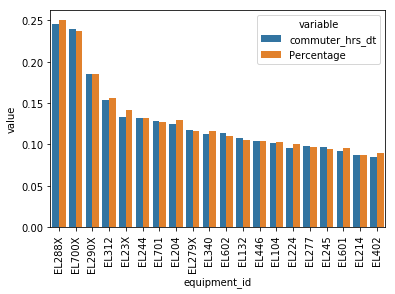

In [135]:
tidy = metrics_by_el.sort_values('avg',ascending=False).head(20).reset_index().melt(id_vars='equipment_id')
g = sns.barplot(x='equipment_id', y='value', hue='variable', data=tidy[(tidy.variable == 'Percentage') | (tidy.variable == 'commuter_hrs_dt')])
g.set_xticklabels(tidy[(tidy.variable == 'Percentage') | (tidy.variable == 'commuter_hr_dt')].equipment_id,rotation=90)

[Text(0, 0, '28 ST'),
 Text(0, 0, '42 ST-PORT AUTH'),
 Text(0, 0, 'CLARK ST'),
 Text(0, 0, 'FRANKLIN AV'),
 Text(0, 0, 'GRD CNTRL-42 ST'),
 Text(0, 0, 'CONEY IS-STILLW'),
 Text(0, 0, 'WORLD TRADE CTR'),
 Text(0, 0, 'COURT SQ'),
 Text(0, 0, 'PARK PLACE'),
 Text(0, 0, 'COURT SQ-23 ST'),
 Text(0, 0, 'FLATBUSH AV-B.C'),
 Text(0, 0, 'GUN HILL RD'),
 Text(0, 0, 'W 4 ST-WASH SQ'),
 Text(0, 0, 'HOYT-SCHER'),
 Text(0, 0, 'LEXINGTON AV/53'),
 Text(0, 0, '161/YANKEE STAD'),
 Text(0, 0, 'OZONE PK LEFFRT'),
 Text(0, 0, '191 ST'),
 Text(0, 0, '34 ST-HUDSON YD'),
 Text(0, 0, 'CHAMBERS ST')]

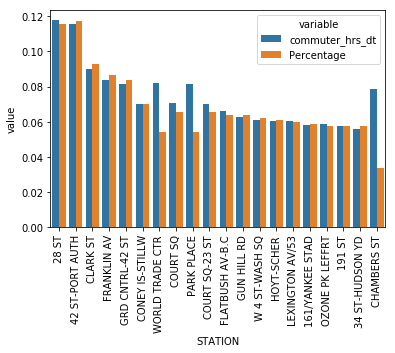

In [136]:
tidy = metrics_by_st.sort_values('avg',ascending=False).head(20).reset_index().melt(id_vars='STATION')
g = sns.barplot(x='STATION', y='value', hue='variable', data=tidy[(tidy.variable == 'Percentage') | (tidy.variable == 'commuter_hrs_dt')])
g.set_xticklabels(tidy[(tidy.variable == 'Percentage') | (tidy.variable == 'commuter_hr_dt')].STATION,rotation=90)

[Text(0, 0, 'CHAMBERS ST'),
 Text(0, 0, 'WORLD TRADE CTR'),
 Text(0, 0, 'PARK PLACE'),
 Text(0, 0, '59 ST COLUMBUS'),
 Text(0, 0, 'TIMES SQ-42 ST'),
 Text(0, 0, 'ATL AV-BARCLAY'),
 Text(0, 0, '34 ST-HERALD SQ'),
 Text(0, 0, 'COURT SQ'),
 Text(0, 0, 'COURT SQ-23 ST'),
 Text(0, 0, 'JAMAICA VAN WK')]

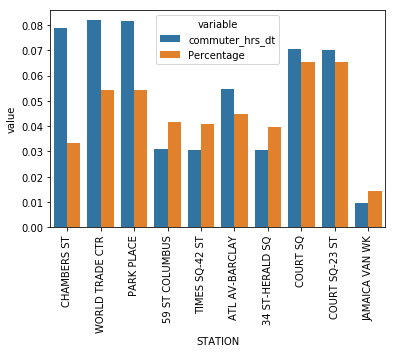

In [137]:
tidy = metrics_by_st.sort_values('diff',ascending=False).head(10).reset_index().melt(id_vars='STATION')
g = sns.barplot(x='STATION', y='value', hue='variable', data=tidy[(tidy.variable == 'Percentage') | (tidy.variable == 'commuter_hrs_dt')])
g.set_xticklabels(tidy[(tidy.variable == 'Percentage') | (tidy.variable == 'commuter_hr_dt')].STATION,rotation=90)

#### System wide measure

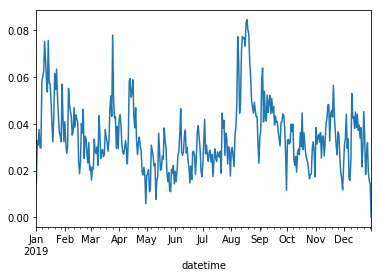

In [138]:
daily_ch_dt_by_el.groupby('datetime').mean().commuter_hrs_dt.plot()

Text(0.5, 0, 'Month')

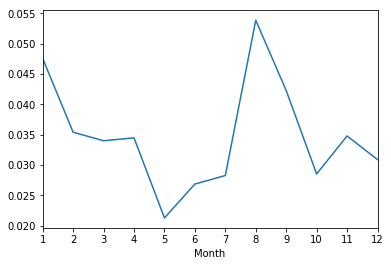

In [139]:
monthly_ch_dt = daily_ch_dt_by_el.groupby(pd.DatetimeIndex(daily_ch_dt_by_el.datetime).month).mean().commuter_hrs_dt
ax = monthly_ch_dt.plot(xticks=range(1,13))
ax.set_xlabel('Month')

In [140]:
monthly_comparison = monthly_downtime.reset_index().merge(monthly_ch_dt.reset_index(),on='datetime')
monthly_comparison.rename(columns={'Percentage':'downtime','datetime':'month'},inplace=True)

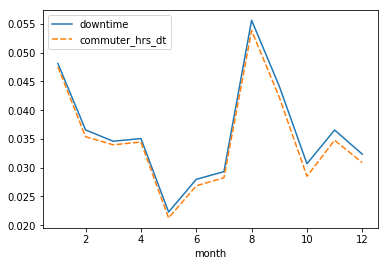

In [141]:
sns.lineplot(data=monthly_comparison.set_index('month'))

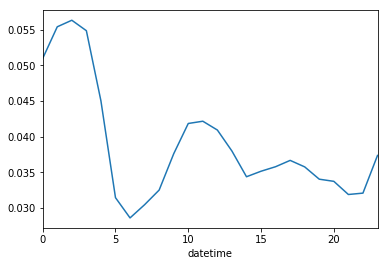

In [142]:
df_elevators.groupby(df_elevators.index.hour).mean()['Percentage'].plot()

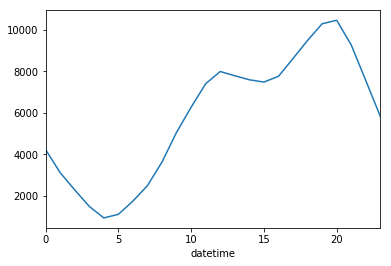

In [143]:
df_elevators.groupby(df_elevators.index.hour).mean()['flow'].plot()

#### MTA maintained vs. Privately maintained

In [144]:
el_ch_dt_by_private = daily_ch_dt_by_el.groupby([pd.DatetimeIndex(daily_ch_dt_by_el.datetime).month,'maintained']).mean().reset_index()

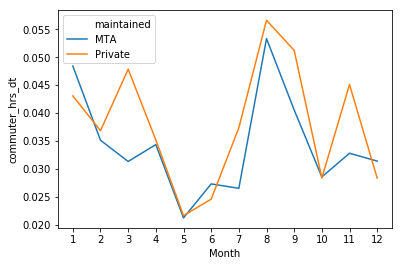

In [145]:
ax = sns.lineplot(x='datetime',y='commuter_hrs_dt',hue='maintained',data=el_ch_dt_by_private)
ax.set_xlabel('Month')
ax.set_xticks(range(1,13))

#### Excluding planned outages

Text(0.5, 0, 'Month')

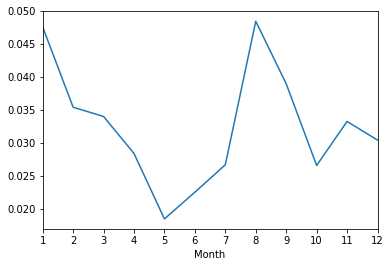

In [146]:
df_el_unplanned = df_elevators[df_elevators['Planned Outage'] != True]
daily_ch_dt_by_el_up = df_el_unplanned.groupby([df_el_unplanned.index.floor('d'),'equipment_id','maintained']).sum()['flow_pct'].div(df_el_unplanned.groupby([df_el_unplanned.index.floor('d'),'equipment_id','maintained']).sum()['flow']).reset_index()
daily_ch_dt_by_el_up.rename(columns={0:'commuter_hrs_dt'},inplace=True)
ax = daily_ch_dt_by_el_up.groupby(pd.DatetimeIndex(daily_ch_dt_by_el_up.datetime).month).mean().commuter_hrs_dt.plot(xticks=range(1,13))
ax.set_xlabel('Month')

#### Avg. flow vs. Avg. outage 

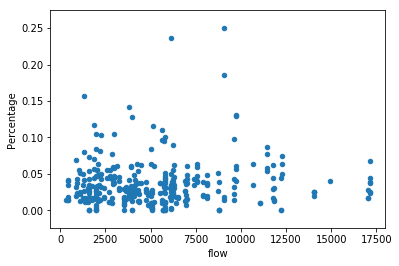

In [147]:
df_elevators.groupby('equipment_id').mean()[['flow','Percentage']].plot.scatter(x='flow',y='Percentage')

#### Commutes impacted

In [148]:
# total_hourly_commuters = df_elevators.groupby('datetime').sum()[['flow']].reset_index().rename(columns={'flow':'total_flow'})
# total_hourly_commuters.head()

In [149]:
# df_elevators = df_elevators.merge(total_hourly_commuters,on='datetime').set_index('datetime')
# df_elevators.rename(columns={'flow_y':'total_flow','flow_x':'flow'},inplace=True)

In [150]:
# df_elevators['total_flow_pct'] = df_elevators['flow']/df_elevators['total_flow']
# df_elevators['pct_commuters_affected'] = df_elevators['total_flow_pct']*df_elevators['Percentage']

In [151]:
daily_commutes_affected_by_el = df_elevators.groupby([df_elevators.index.floor('d'),'equipment_id']).sum()[['flow_pct']].reset_index()
daily_commutes_affected_by_st = df_elevators.groupby([df_elevators.index.floor('d'),'STATION']).sum()[['flow_pct']].reset_index()

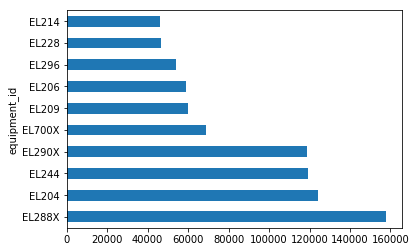

In [152]:
daily_commutes_affected_by_el.groupby('equipment_id').mean().sort_values('flow_pct',ascending=False).flow_pct.head(10).plot.barh()

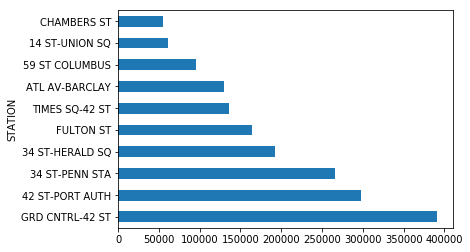

In [153]:
daily_commutes_affected_by_st.groupby('STATION').mean().sort_values('flow_pct',ascending=False).flow_pct.head(10).plot.barh()